# Demo: Explain Anomaly Detection Models with GEAD

> Here we provide a step-by-step demo of explaining an autoencoder-based anomaly detection model with GEAD.

> **Note**: This demo will train and explain the AD model from scratch, and we also already saved the intermediate results in `demo/save/`. 

In [1]:
# jupyter setting
%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2
from IPython.display import IFrame

In [2]:
# general packages
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import _pickle as pkl
import yaml

# gead moudles
sys.path.append('../code/')
import AE
import process_utils, eval_utils, tree_utils, analyse_utils
from gead import GEADUsage
from process_utils import CicDataLoader

/data1/wk/anaconda3/envs/GEAD/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing Data and Training AD model

> In this demo, we will use [CIC-IDS2017 dataset](https://www.unb.ca/cic/datasets/ids-2017.html) to train an autoencoder-based anomaly detection model (such as [Kitsune](https://github.com/ymirsky/Kitsune-py)). We use the Tuesday traffic set for train and evaluation. For the sake of simplicity, this demo does not use the OOD evaluation mentioned in our paper, which is used in `experiment/`.

In [3]:
# load and pre-processing tuesday dataset
csv_pths = ['Tuesday-WorkingHours.pcap_ISCX.csv']
dl = CicDataLoader(improved=False)
X_all, y_all = dl.load_data(csv_pths[0])
dataset, normalizer = dl.data_split_norm(X_all, y_all, 
                    norm='train_ben',
                    n_train_ben=0.5,
                    n_train=0.5,
                    n_vali=0.25,
                    n_test=0.25)
feature_names = dl.feature_name

Processed Tuesday-WorkingHours.pcap_ISCX.csv, total 445909 items (ben: 432074, mal: 13835)
X_all:       445909 (ben: 432074, mal: 13835)
X_train_ben: 222954 (ben: 222954, mal: 0)
X_train:     222954 (ben: 215890, mal: 7064)
X_vali:      111477 (ben: 108113, mal: 3364)
X_test:      111478 (ben: 108071, mal: 3407)


In [4]:
# training AD model
process_utils.set_random_seed() # fix random seed
model = AE.train_valid(dataset['X_train_ben'], dataset['X_train_ben'].shape[1], dataset['X_vali'] , dataset['y_vali'], 
            epoches=20, lr=1e-4, verbose=False)
y_test_pred, y_test_rmse = AE.test(model, dataset['X_test'])
roc_auc, best_thres = AE.eval_roc(y_test_rmse, dataset['y_test'], thres_max=model.thres*1.5, plot=False)

print('\nPerformance on Validation Set:')
AE.TPR_FPR(y_test_rmse, dataset['y_test'], best_thres, verbose=True)

# save model
pkl.dump(model, open('save/demo_cicids17_tuesday.model','wb'))

NOTICE: use rmse as the criteration of reconstruction error
roc_auc: 0.7528391898990123

Performance on Validation Set:
TPR: 0.9973583798062519 FPR: 0.40366980966216615
TN: 64446 TP: 3398 FP: 43625 FN: 9


> **Note**: As mentioned in our paper, the results trained on Tuesday dataset is relatively poor (aligned with other related works). We'll use GEAD to explain the decision logic and figure out the reason. In other words, GEAD can extract the rules of AD model with high fidelity, regardless of its original performance.

## Explain AD model with GEAD

> In order to avoid too long running time, the grid search process is omitted here, and this part of the implementation is already provided in `code/gead.py > grid_search()`.

In [5]:
# load configured hyperparameters 
with open('demo.yml', 'r') as file:
    configs = yaml.safe_load(file)
rt_params, lc_params, aug_params, aug_settings = configs['rt_params'], configs['lc_params'], configs['aug_params'], configs['aug_settings']
    
# initialize GEAD
gead_usage = GEADUsage(model, feature_names, verbose=True, debug=False, **rt_params)

# build explainable model in GEAD
gead_usage.build_params(dataset['X_train_ben'], lc_params, aug_params, aug_settings)

# evluation fidelity between explainable and original models
gead_usage.eval_gead_merged(dataset['X_test'])


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++ 1. Building Root Regression Tree and Identifying Low-confidence Leaves ++++
(LC Leaves Number) Total: 24, DT(impurity):11, NN(value): 21
Get root regression tree from scratch
 - Number of leaf nodes: 41
 - Max Depth: 12
 - Prob Threshold: 0.13750159740447998
 - Impurity Threshold: 0.00025392144865943843
 - Low-confidence leaves: 24 (0.59)(dt_lc:11, nn_lc:21)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++ 2. Data Augmentation for Low-confidence Leaves ++++++++++++++++


100%|███████████████████████████████████████████| 24/24 [00:01<00:00, 15.28it/s]


NOTICE: Finish data augmentataion! Total augment 22611 -> 201430 samples

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+++++++++++++++ 3. Building Low-confidence Fine-grained Subtrees +++++++++++++++
Generate fine-grained rules for LC Leaves: (no., leaves, max_depth):
[  0,  2, 1][  1,  1, 0][  2,  1, 0][  3,  1, 0][  4,  1, 0][  5,  1, 0]
[  6,  1, 0][  7,  1, 0][  8,  2, 1][  9,  3, 2][ 10,  4, 2][ 11,  4, 2]
[ 12,  3, 2][ 13,  4, 2][ 14,  4, 2][ 15,  3, 2][ 16,  1, 0][ 17,  1, 0]
[ 18,  4, 2][ 19,  1, 0][ 20,  1, 0][ 21,  1, 0][ 22,  1, 0][ 23,  1, 0]
NOTICE: Finish fine-grained rules genereation! Total augment 47 rules

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+++++++++++++++ 4. Merging Subtrees into Roottree -> Merged Tree +++++++++++++++

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++ 5. Binarizing Merged Tree +++++++++++++++++++++++++++
NOTICE:

## Visualize GEAD Rule Tree

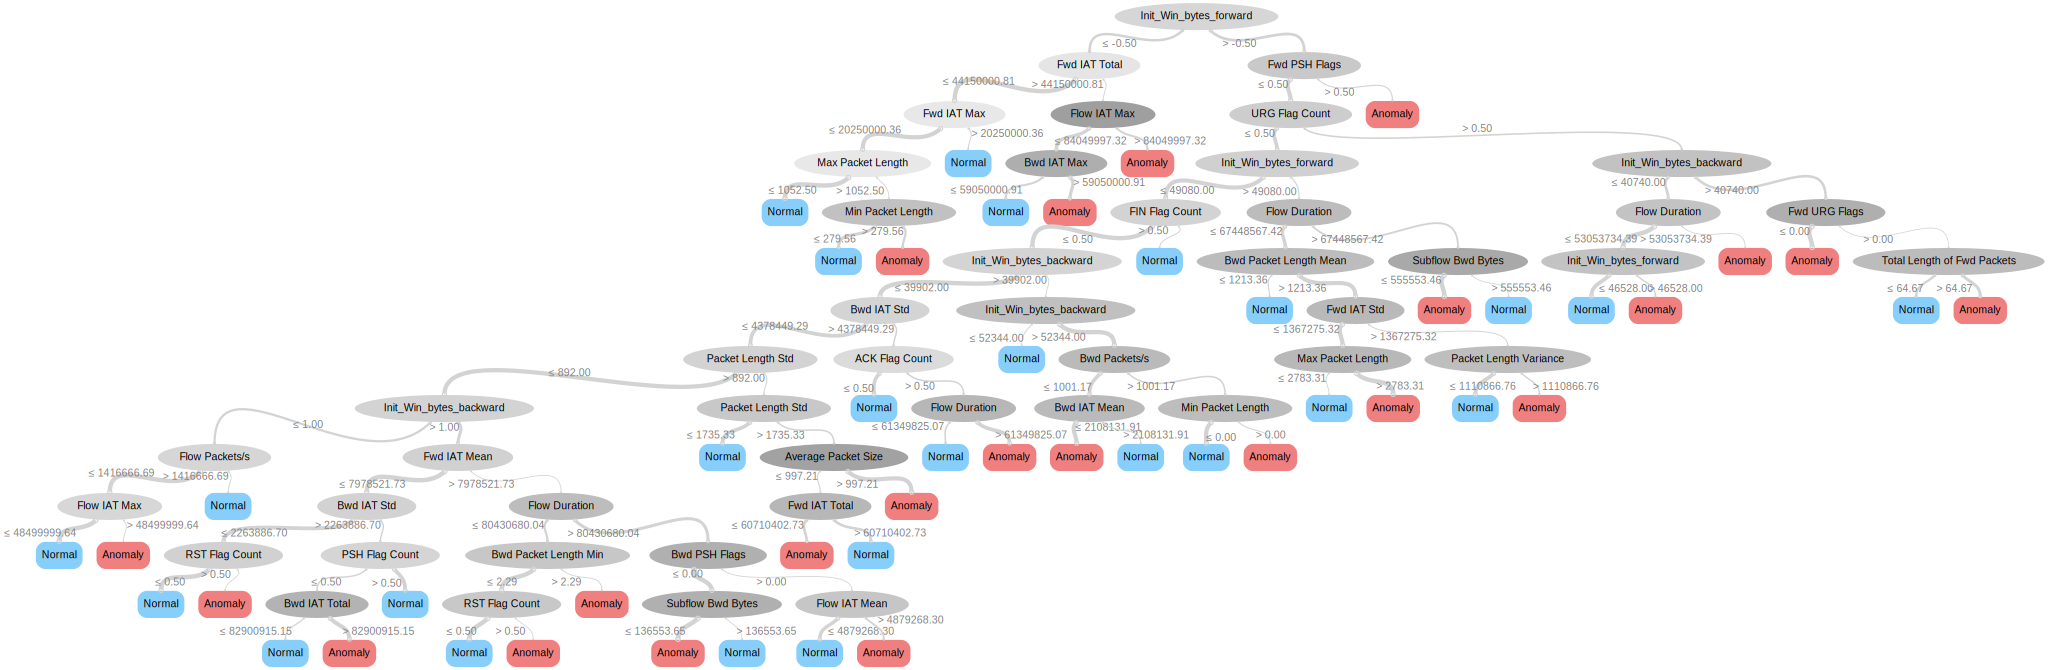

In [6]:
tp = tree_utils.TreePlotter(gead_usage.merged_tree, feature_names=dl.feature_name)
graph = tp.plot_reg_tree(gead_usage.ad_thres, branch_condition=True, normalizer=normalizer,
                        save_pth='save/rule_tree_demo_cicids17_tuesday')
display(graph)

In [7]:
# show saved ruled tree in PDF format
IFrame('save/rule_tree_demo_cicids17_tuesday.pdf', width=800, height=600)

> The plotted rule tree is consistent consistent with the paper. Please refer to Section 4.3.1 for more details of why the AD model under this dataset is with poor performance (such as wrong features and labels).